<a href="https://colab.research.google.com/github/Ermi1223/conditional-diffusion-tutorial/blob/main/conditional_diffusion_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Step 1: Setup GPU Acceleration**

In [ ]:
# First cell: Setup GPU
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.6.0+cu124
CUDA available: True
GPU: Tesla T4


**Step 2: Install Required Packages**

In [ ]:
# Second cell: Install dependencies
!pip install torch torchvision matplotlib tqdm ipywidgets
!pip install diffusers transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 28.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 829.9 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

**Step 3: Import Libraries and Configuration**

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from diffusers import DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer

# Configuration
IMG_SIZE = 32
BATCH_SIZE = 64
TIMESTEPS = 500  # Reduced for faster training
NUM_EPOCHS = 10  # Reduced for demonstration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
PyTorch version: 2.6.0+cu124
GPU: Tesla T4


**Step 4: Dataset Preparation**

In [8]:
from transformers import CLIPTokenizer, CLIPTextModel

# Load CLIP once (global)
clip_tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
clip_text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE).eval()

# Precompute embeddings (only 10 CIFAR classes)
class_to_text = {
    0: "an airplane flying in the sky",
    1: "an automobile on the road",
    2: "a bird perched on a branch",
    3: "a cat sitting on a windowsill",
    4: "a deer in the forest",
    5: "a dog playing in the park",
    6: "a frog on a lily pad",
    7: "a horse running in a field",
    8: "a ship sailing on the ocean",
    9: "a truck driving on the highway"
}

precomputed_embeddings = {}
for label, text in class_to_text.items():
    inputs = clip_tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(DEVICE)
    with torch.no_grad():
        text_emb = clip_text_encoder(**inputs).last_hidden_state.mean(dim=1)
    precomputed_embeddings[label] = text_emb.squeeze(0).cpu()  # move to CPU for safety

# Dataset Class
class CIFAR10Conditional(Dataset):
    def __init__(self, root, train=True):
        super().__init__()
        self.cifar = datasets.CIFAR10(
            root=root, train=train, download=True,
            transform=transforms.Compose([
                transforms.Resize(IMG_SIZE),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])
            ])
        )

    def __len__(self):
        return len(self.cifar)

    def __getitem__(self, idx):
        img, label = self.cifar[idx]
        text_emb = precomputed_embeddings[label]
        return img, label, text_emb

# Load Data
train_dataset = CIFAR10Conditional(root='./data', train=True)
test_dataset = CIFAR10Conditional(root='./data', train=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=2, pin_memory=True)



print(f"Train dataset size: {len(train_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]


  0%|          | 0.00/170M [00:00<?, ?B/s]
  0%|          | 32.8k/170M [00:00<18:03, 157kB/s]
  0%|          | 65.5k/170M [00:00<18:26, 154kB/s]
  0%|          | 98.3k/170M [00:00<18:11, 156kB/s]
  0%|          | 197k/170M [00:00<10:10, 279kB/s] 
  0%|          | 426k/170M [00:01<04:58, 570kB/s]
  0%|          | 688k/170M [00:01<03:32, 799kB/s]
  1%|          | 1.41M/170M [00:01<01:42, 1.65MB/s]
  2%|▏         | 2.82M/170M [00:01<00:51, 3.25MB/s]
  3%|▎         | 5.64M/170M [00:01<00:25, 6.41MB/s]
  5%|▌         | 8.95M/170M [00:02<00:17, 9.28MB/s]
  7%|▋         | 12.5M/170M [00:02<00:13, 11.5MB/s]
  9%|▉         | 16.0M/170M [00:02<00:12, 12.6MB/s]
 11%|█         | 18.8M/170M [00:02<00:11, 12.8MB/s]
 13%|█▎        | 21.5M/170M [00:02<00:11, 12.8MB/s]
 15%|█▍        | 25.2M/170M [00:03<00:10, 13.7MB/s]
 17%|█▋        | 28.1M/170M [00:03<00:10, 13.6MB/s]
 19%|█▊        | 31.9M/170M [00:03<00:09, 14.8MB/s]
 21%|██        | 35.3M/170M [00:03<00:08, 15.1MB/s]
 23%|██▎       | 38.8M/170M 

Train dataset size: 50000
Test dataset size: 10000


**Step 5: Model Architecture**

In [9]:
class TimeEmbedding(nn.Module):
    """Sinusoidal time embedding"""
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        half_dim = self.dim // 2
        emb = torch.log(torch.tensor(10000.0)) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=DEVICE) * -emb)
        emb = t[:, None] * emb[None, :]
        return torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)

class ConditionalBlock(nn.Module):
    """U-Net block with conditioning"""
    def __init__(self, in_ch, out_ch, time_dim, cond_dim):
        super().__init__()
        self.time_layer = nn.Sequential(
            nn.Linear(time_dim, out_ch),
            nn.SiLU()
        )
        self.cond_layer = nn.Sequential(
            nn.Linear(cond_dim, out_ch),
            nn.SiLU()
        )
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(8, out_ch),
            nn.SiLU()
        )
        self.residual = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, t_emb, c_emb):
        h = self.conv(x) + self.residual(x)
        t_emb = self.time_layer(t_emb)
        c_emb = self.cond_layer(c_emb)
        scale = t_emb + c_emb
        scale = scale.view(scale.shape[0], scale.shape[1], 1, 1)
        return h * scale

class ConditionalUNet(nn.Module):
    """U-Net with conditioning for diffusion"""
    def __init__(self):
        super().__init__()
        time_dim = 128
        cond_dim = 512  # Match CLIP output size

        # Time embedding
        self.time_mlp = nn.Sequential(
            TimeEmbedding(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.SiLU(),
            nn.Linear(time_dim, time_dim)
        )

        # Class embedding
        self.class_embed = nn.Embedding(10, cond_dim)

        # Conditioning projection
        self.cond_proj = nn.Sequential(
            nn.Linear(cond_dim, cond_dim),
            nn.SiLU(),
            nn.Linear(cond_dim, cond_dim)
        )

        # Down blocks
        self.down1 = ConditionalBlock(3, 64, time_dim, cond_dim)
        self.down2 = ConditionalBlock(64, 128, time_dim, cond_dim)
        self.down3 = ConditionalBlock(128, 256, time_dim, cond_dim)

        # Bottleneck
        self.bottleneck = ConditionalBlock(256, 512, time_dim, cond_dim)

        # Up blocks
        self.up1 = ConditionalBlock(512 + 256, 256, time_dim, cond_dim)
        self.up2 = ConditionalBlock(256 + 128, 128, time_dim, cond_dim)
        self.up3 = ConditionalBlock(128 + 64, 64, time_dim, cond_dim)

        # Output
        self.out = nn.Conv2d(64, 3, 1)

        # Pooling/upsampling
        self.downsample = nn.AvgPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x, t, class_labels, text_emb):
        # Embeddings
        t_emb = self.time_mlp(t)
        c_emb = self.class_embed(class_labels) + self.cond_proj(text_emb)

        # Down path
        d1 = self.down1(x, t_emb, c_emb)
        d2 = self.down2(self.downsample(d1), t_emb, c_emb)
        d3 = self.down3(self.downsample(d2), t_emb, c_emb)

        # Bottleneck
        b = self.bottleneck(self.downsample(d3), t_emb, c_emb)

        # Up path with skip connections
        u1 = self.up1(torch.cat([self.upsample(b), d3], dim=1), t_emb, c_emb)
        u2 = self.up2(torch.cat([self.upsample(u1), d2], dim=1), t_emb, c_emb)
        u3 = self.up3(torch.cat([self.upsample(u2), d1], dim=1), t_emb, c_emb)

        return self.out(u3)

# Create model
model = ConditionalUNet().to(DEVICE)
print(f"Model created with {sum(p.numel() for p in model.parameters()):,} parameters")

Model created with 9,687,747 parameters


**Step 6:Diffusion Utilities**

In [20]:
class Diffusion:
    """Handles forward and reverse diffusion processes"""
    def __init__(self, timesteps=TIMESTEPS):
        self.timesteps = timesteps

        self.betas = torch.linspace(1e-4, 0.02, timesteps, device=DEVICE)
        self.alphas = 1. - self.betas
        self.alpha_bars = torch.cumprod(self.alphas, dim=0)

    def forward_process(self, x0, t):
        """Add noise to image at timestep t"""
        t = t.to(DEVICE)
        sqrt_alpha_bar = torch.sqrt(self.alpha_bars[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1. - self.alpha_bars[t])[:, None, None, None]
        noise = torch.randn_like(x0)
        noisy_img = sqrt_alpha_bar * x0 + sqrt_one_minus_alpha_bar * noise
        return noisy_img, noise



    def reverse_process(self, model, noisy_img, t, class_labels, text_emb, noise_pred=None):
        """Predict and remove noise from image"""
        if noise_pred is None:
            noise_pred = model(noisy_img, t, class_labels, text_emb)

        # Compute coefficients
        alpha_t = self.alphas[t][:, None, None, None]
        alpha_bar_t = self.alpha_bars[t][:, None, None, None]
        beta_t = self.betas[t][:, None, None, None]
        sqrt_alpha_t = torch.sqrt(alpha_t)
        sqrt_one_minus_alpha_bar_t = torch.sqrt(1 - alpha_bar_t)

        # Predict x0
        pred_x0 = (noisy_img - sqrt_one_minus_alpha_bar_t * noise_pred) / torch.sqrt(alpha_bar_t)

        # Direction pointing to x_t
        dir_xt = torch.sqrt(1 - alpha_t) * noise_pred

        # Reverse diffusion step
        prev_noisy = (1 / sqrt_alpha_t) * (noisy_img - dir_xt)

        return prev_noisy, pred_x0

# Initialize diffusion utilities
diffusion = Diffusion()
print(f"Diffusion process initialized with {TIMESTEPS} timesteps")

Diffusion process initialized with 500 timesteps


**Step7: Training Function**

In [21]:
def train_diffusion_model():
    """Train conditional diffusion model"""
    # Initialize components
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(NUM_EPOCHS):
        model.train()
        epoch_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_EPOCHS}")

        for imgs, labels, text_embs in progress_bar:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)
            text_embs = text_embs.to(DEVICE)

            # Random timesteps
            t = torch.randint(0, diffusion.timesteps, (imgs.size(0),), device=DEVICE)


            # Forward process
            noisy_imgs, noise = diffusion.forward_process(imgs, t)

            # Predict noise
            noise_pred = model(noisy_imgs, t, labels, text_embs)

            # Loss and optimize
            loss = F.mse_loss(noise_pred, noise)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_loss = epoch_loss / len(train_loader)
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f}")

    return model, diffusion

# Start training
print("Starting training...")
trained_model, diffusion = train_diffusion_model()
print("Training completed!")

Starting training...


Epoch 1/10: 100%|██████████| 782/782 [01:13<00:00, 10.65it/s, loss=0.0922]


Epoch 1 | Loss: 0.1146


Epoch 2/10: 100%|██████████| 782/782 [01:13<00:00, 10.71it/s, loss=0.0461]


Epoch 2 | Loss: 0.0608


Epoch 3/10: 100%|██████████| 782/782 [01:08<00:00, 11.39it/s, loss=0.0328]


Epoch 3 | Loss: 0.0565


Epoch 4/10: 100%|██████████| 782/782 [01:08<00:00, 11.50it/s, loss=0.036]


Epoch 4 | Loss: 0.0540


Epoch 5/10: 100%|██████████| 782/782 [01:08<00:00, 11.49it/s, loss=0.0401]


Epoch 5 | Loss: 0.0523


Epoch 6/10: 100%|██████████| 782/782 [01:07<00:00, 11.55it/s, loss=0.0864]


Epoch 6 | Loss: 0.0521


Epoch 7/10: 100%|██████████| 782/782 [01:07<00:00, 11.55it/s, loss=0.0933]


Epoch 7 | Loss: 0.0518


Epoch 8/10: 100%|██████████| 782/782 [01:07<00:00, 11.61it/s, loss=0.0705]


Epoch 8 | Loss: 0.0503


Epoch 9/10: 100%|██████████| 782/782 [01:07<00:00, 11.60it/s, loss=0.0533]


Epoch 9 | Loss: 0.0501


Epoch 10/10: 100%|██████████| 782/782 [01:07<00:00, 11.53it/s, loss=0.0356]

Epoch 10 | Loss: 0.0494
Training completed!


**Step 8: Sampling and Visualization Functions**

Testing visualization with sample image...


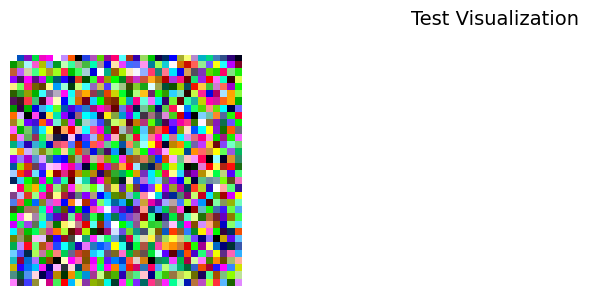

If you see a random image above, visualization is working!


In [28]:
@torch.no_grad()
def sample(model, diffusion, num_samples=1, class_label=None, text_prompt=None,
           return_steps=False, steps=5):
    """Generate samples with denoising visualization"""
    model.eval()

    # Prepare conditioning
    if class_label is not None:
        class_labels = torch.tensor([class_label] * num_samples).to(DEVICE)
    else:
        class_labels = torch.zeros(num_samples, dtype=torch.long).to(DEVICE)

    if text_prompt:
        # Tokenize text prompt
        tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-base-patch32")
        text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-base-patch32").to(DEVICE)
        inputs = tokenizer([text_prompt]*num_samples, return_tensors="pt", padding=True, truncation=True)
        inputs = {k: v.to(DEVICE) for k, v in inputs.items()}
        text_emb = text_encoder(**inputs).last_hidden_state.mean(dim=1)
    else:
        # Use default text embedding
        text_emb = torch.randn(num_samples, 512).to(DEVICE)

    # Start from pure noise
    x = torch.randn(num_samples, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)
    intermediates = []
    step_size = diffusion.timesteps // steps

    # Reverse diffusion process
    for t in range(diffusion.timesteps-1, -1, -1):
        t_batch = torch.tensor([t] * num_samples).to(DEVICE)

        # Predict noise
        noise_pred = model(x, t_batch, class_labels, text_emb)

        # Reverse step
        x, _ = diffusion.reverse_process(model, x, t_batch, class_labels, text_emb, noise_pred)

        # Store intermediates
        if return_steps and t % step_size == 0:
            intermediates.append(x.detach().cpu())

    return (x, intermediates) if return_steps else x

def visualize_denoising(intermediates, title="Denoising Process"):
    """Visualize denoising progression"""
    plt.figure(figsize=(15, 3))
    num_steps = len(intermediates)

    for i, img in enumerate(intermediates):
        # Handle tensor conversion and normalization
        img = img[0].permute(1, 2, 0).numpy()  # Convert to HWC numpy array
        img = img * 0.5 + 0.5  # Denormalize from [-1,1] to [0,1]
        img = np.clip(img, 0, 1)

        plt.subplot(1, num_steps, i+1)
        plt.imshow(img)
        plt.title(f"Step {i * (diffusion.timesteps // num_steps)}")
        plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()  # Explicitly show the plot

def visualize_samples(samples, title="Generated Samples"):
    """Visualize generated samples"""
    # Convert to numpy and denormalize
    samples = samples.cpu().permute(0, 2, 3, 1).numpy()
    samples = samples * 0.5 + 0.5
    samples = np.clip(samples, 0, 1)

    plt.figure(figsize=(10, 3))
    for i in range(min(4, samples.shape[0])):
        plt.subplot(1, 4, i+1)
        plt.imshow(samples[i])
        plt.axis('off')
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png")
    plt.show()  # Explicitly show the plot

# Test visualization with a sample image
print("Testing visualization with sample image...")
test_img = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).cpu()
visualize_samples(test_img, title="Test Visualization")
print("If you see a random image above, visualization is working!")

**Step 9:Experiment Workflow**


Running experiments...

Generating images for class: flying


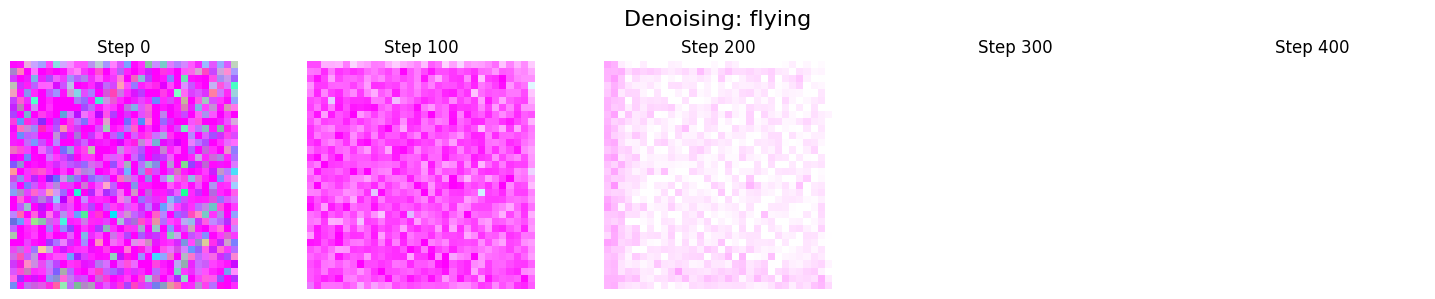

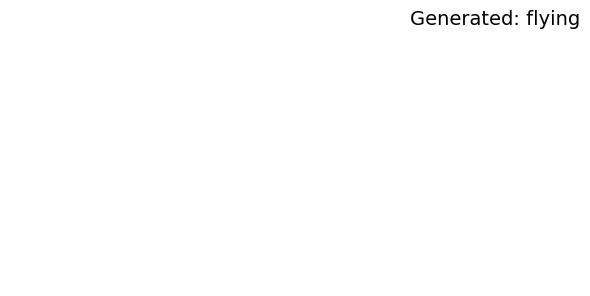


Generating images for class: on


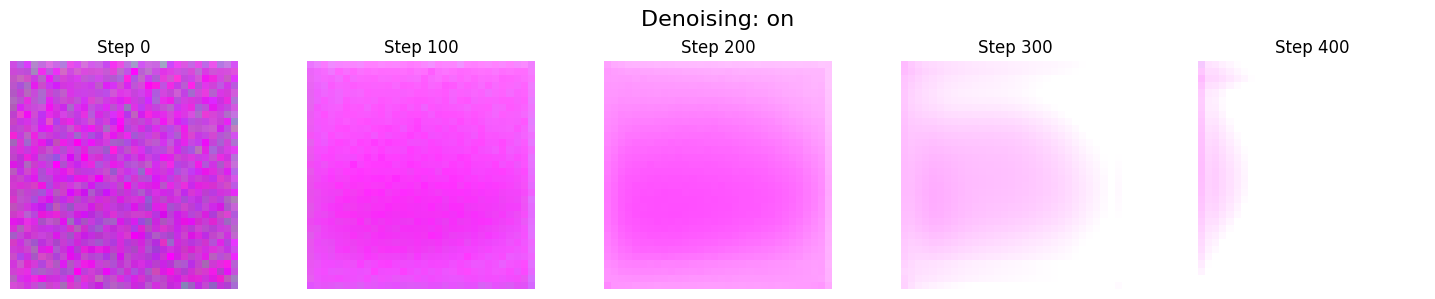

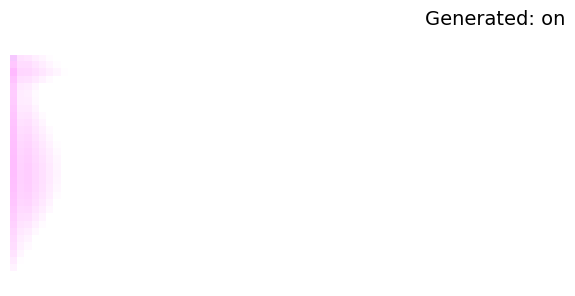


Generating images for class: perched


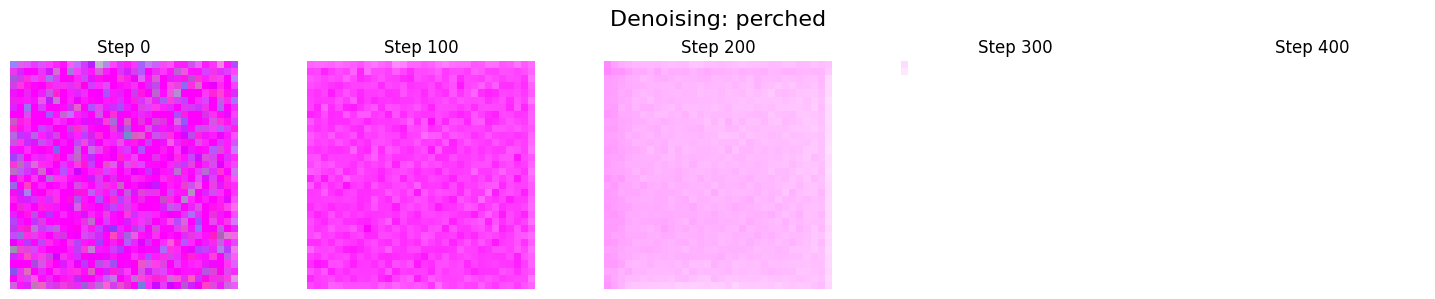

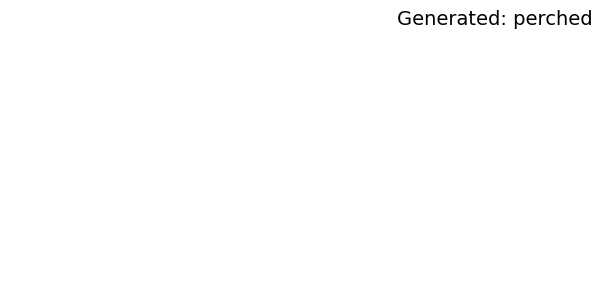


Generating images for prompt: a red sports car on a race track


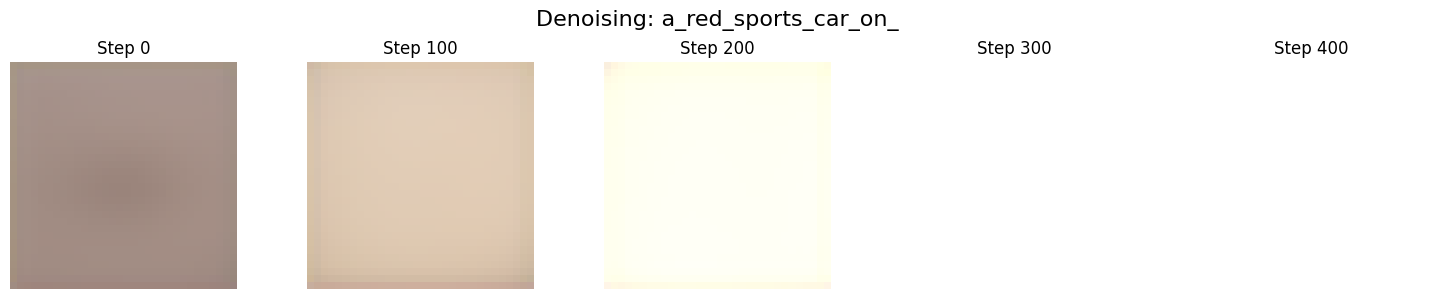

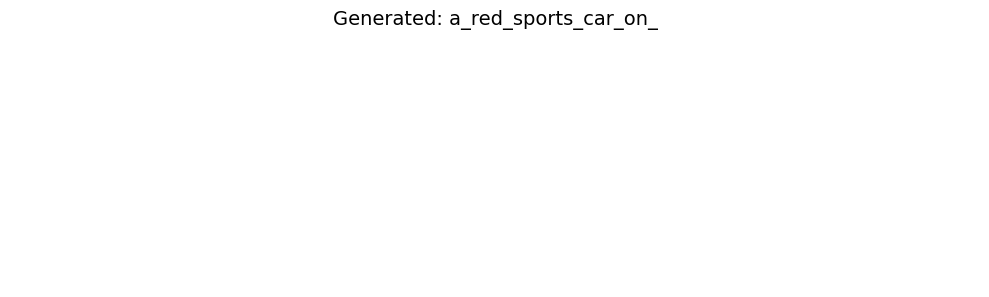


Generating images for prompt: a majestic lion in the savannah


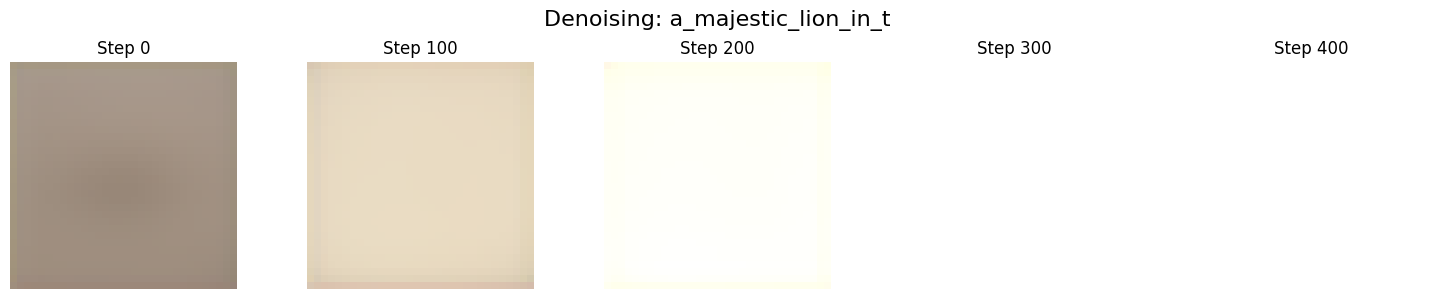

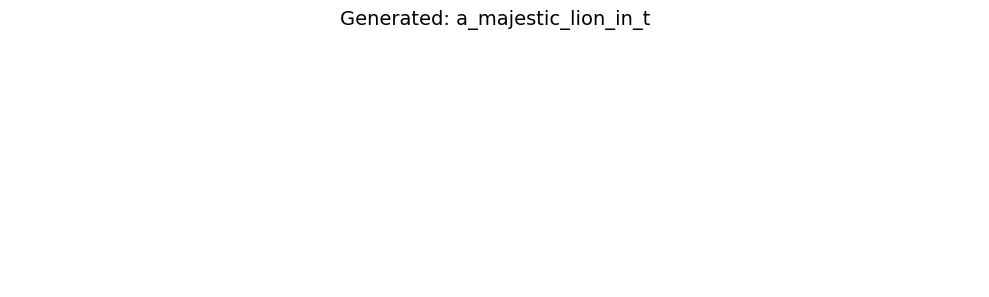


Generating images for prompt: a mountain range at sunset


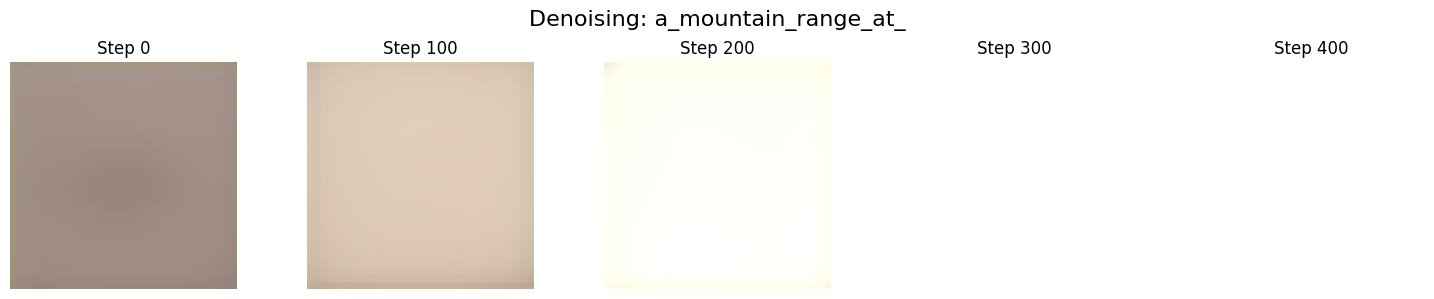

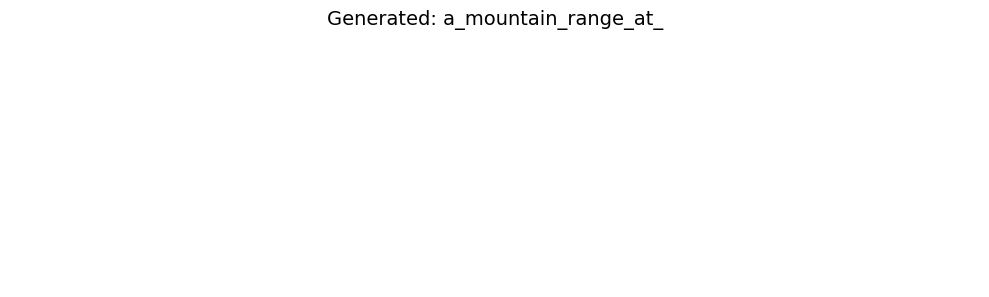


Generating images for prompt: a red sports car on a race track


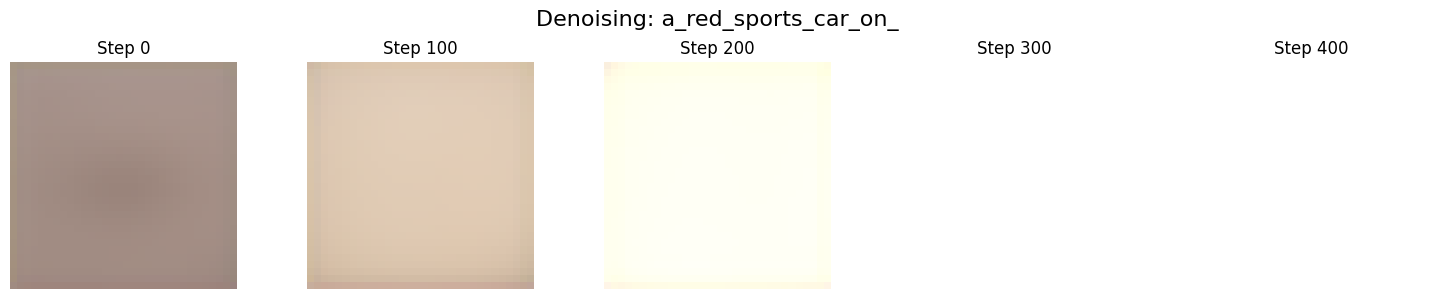

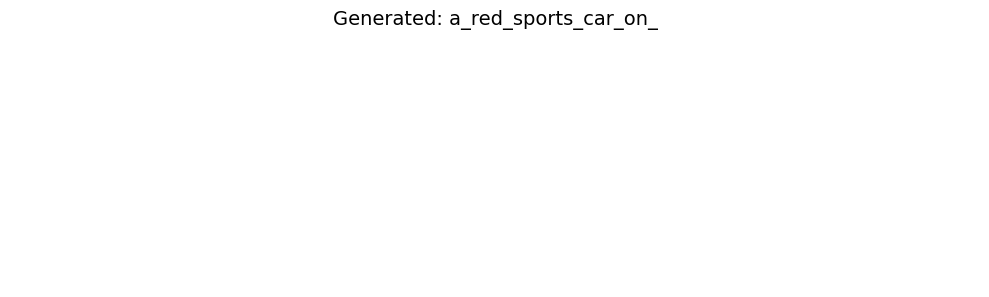


Generating images for prompt: a majestic lion in the savannah


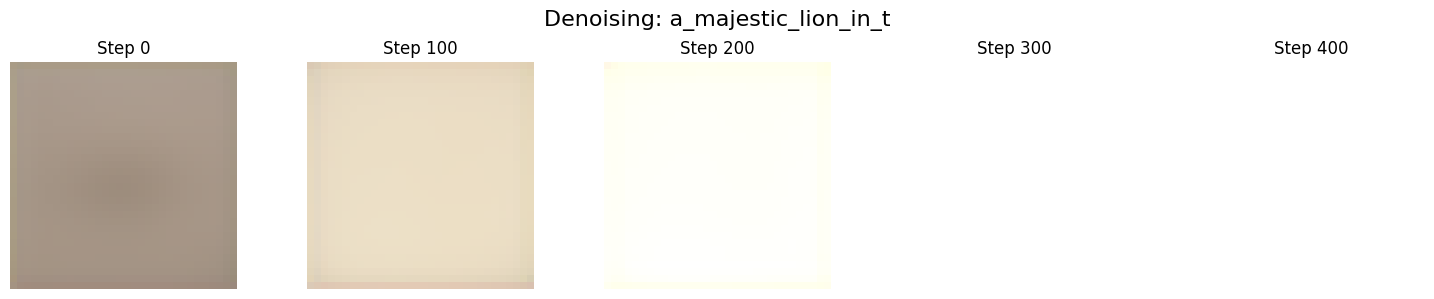

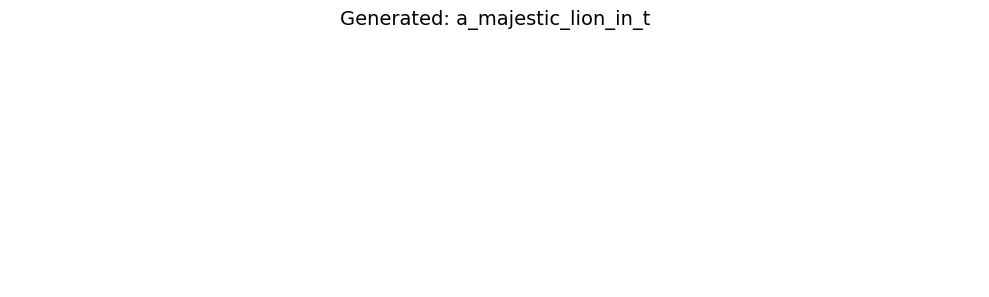


Generating images for prompt: a mountain range at sunset


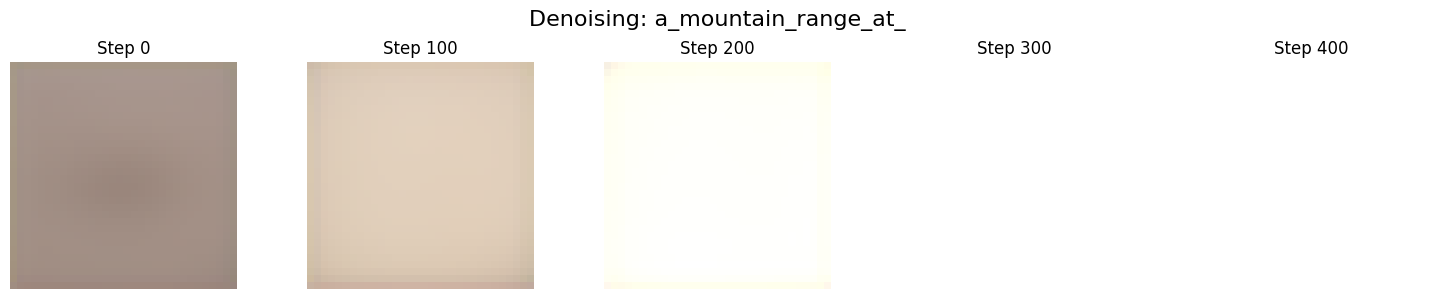

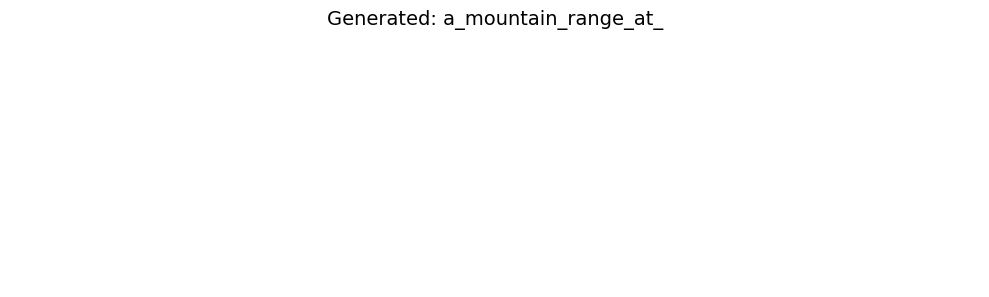

Experiments completed!


In [36]:
def run_experiments(model, diffusion, class_to_text):
    """Run all required experiments"""

    # Experiment 1: Class conditioning with precomputed texts
    for class_id in range(3):  # Just 3 classes for demo
        samples, intermediates = sample(
            model, diffusion,
            num_samples=1,
            class_label=class_id,
            return_steps=True
        )

        # Use the class_to_text mapping
        class_name = class_to_text[class_id].split(' ')[2]  # e.g., "airplane"
        print(f"\nGenerating images for class: {class_name}")
        visualize_denoising(intermediates, title=f"Denoising: {class_name}")
        visualize_samples(samples, title=f"Generated: {class_name}")

    # Experiment 2: Free-form text prompts
    prompts = [
        "a red sports car on a race track",
        "a majestic lion in the savannah",
        "a mountain range at sunset"
    ]

    for prompt in prompts:
        print(f"\nGenerating images for prompt: {prompt}")
        samples, intermediates = sample(
            model, diffusion,
            num_samples=4,
            text_prompt=prompt,
            return_steps=True
        )
        short_prompt = prompt[:20].replace(' ', '_')
        visualize_denoising(intermediates, title=f"Denoising: {short_prompt}")
        visualize_samples(samples, title=f"Generated: {short_prompt}")


    # Experiment 2: Text prompt engineering
    prompts = [
        "a red sports car on a race track",
        "a majestic lion in the savannah",
        "a mountain range at sunset"
    ]

    for prompt in prompts:
        # Generate samples
        print(f"\nGenerating images for prompt: {prompt}")
        samples, intermediates = sample(
            model, diffusion,
            num_samples=4,
            text_prompt=prompt,
            return_steps=True
        )

        # Visualize
        short_prompt = prompt[:20].replace(' ', '_')
        visualize_denoising(intermediates, title=f"Denoising: {short_prompt}")
        visualize_samples(samples, title=f"Generated: {short_prompt}")

# Run experiments
print("\nRunning experiments...")
run_experiments(trained_model, diffusion, class_to_text)


print("Experiments completed!")